In [206]:
import openvino as ov
import numpy as np
import sys
import cv2
from PIL import Image
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import multiprocessing as mp

In [207]:
core = ov.Core()

In [208]:
model = core.read_model(model="./model/human-pose-estimation.xml")
compiled_model = core.compile_model(model=model, device_name="CPU")

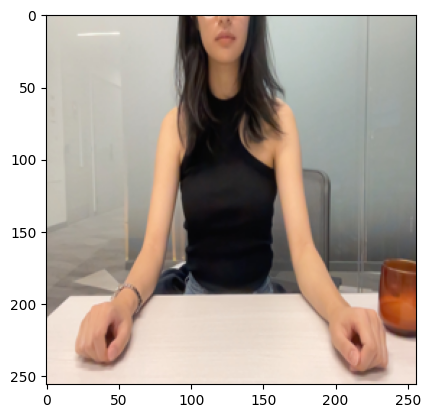

In [386]:
infer_request = compiled_model.create_infer_request()

#image = Image.open("./validtest.jpg")
image = Image.open("/Users/karenliu/Documents/Photo on 2023-11-24 at 4.15 PM #2.jpg")
#image = Image.open("/Users/karenliu/Documents/Photo on 2023-11-24 at 4.28 PM.jpg")
image = image.resize((256, 256))
image.load()
image = np.asarray(image, dtype=np.float32)

image = np.expand_dims(image, axis=0)
image = np.ascontiguousarray(np.transpose(image, (0, 3, 1, 2)))

temp = np.squeeze(image, axis=0)
temp = np.transpose(temp, (1, 2, 0))
plt.imshow(np.uint8(temp))

input_tensor = ov.Tensor(array=image, shared_memory=True)
infer_request.set_input_tensor(input_tensor)

In [354]:
infer_request.start_async()
infer_request.wait()

In [355]:
output = infer_request.get_output_tensor()
output_buffer = output.data

In [356]:
output_buffer = np.squeeze(output_buffer, axis=0)
output_buffer = np.transpose(output_buffer, axes=(1, 2, 0))
heatmaps = cv2.resize(
    output_buffer, (256, 256), fx=8, fy=8, interpolation=cv2.INTER_CUBIC
)

In [357]:
def extract_keypoints(heatmap, min_confidence=0.1):
    ind = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)
    print(heatmap[ind])
    if heatmap[ind] < min_confidence:
        ind = (-1, -1)
    else:
        ind = (int(ind[1]), int(ind[0]))
    return ind

In [358]:
keypoints = []
for kpt_idx in range(16):
    keypoints.append(extract_keypoints(heatmaps[:, :, kpt_idx]))

0.020284295
0.017521087
0.016364299
0.01073347
0.009273173
0.03050459
0.033077948
0.18420511
0.6147581
0.07282954
0.5242313
0.10939753
0.37168458
0.6499061
0.26349026
0.34752703


In [359]:
print(keypoints)

[(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (123, 127), (123, 36), (-1, -1), (55, 197), (78, 164), (87, 74), (163, 70), (177, 165), (204, 206)]


123 127
123 36
55 197
78 164
87 74
163 70
177 165
204 206


'\nfor id in range(7, 16):\n    keypoint = keypoints[id]\n    if keypoint[0] != -1:\n       #ax.add_patch(Circle((int(keypoint[0]), int(keypoint[1]))))\n       pose_ret[2 * (id - 7)] = int(keypoint[0])\n       pose_ret[2 * (id - 7) + 1] = int(keypoint[1])\n'

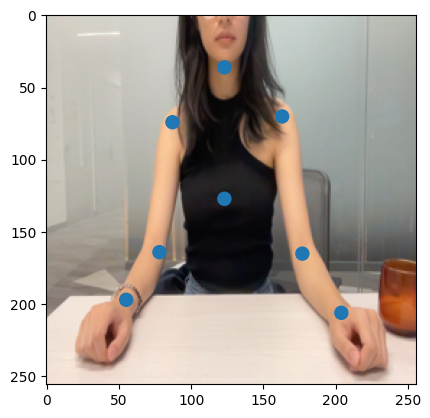

In [360]:
kpt_names = [
    "r_ank",
    "r_kne",
    "r_hip",
    "l_hip",
    "l_kne",
    "l_ank",
    "pel",
    "spi",
    "nec",
    "hea",
    "r_wri",
    "r_elb",
    "r_sho",
    "l_sho",
    "l_elb",
    "l_wri",
]
colors = [
    (255, 0, 0),
    (255, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
    (0, 0, 255),
    (0, 0, 255),
    (0, 255, 0),
    (0, 255, 0),
    (0, 255, 0),
    (0, 255, 0),
    (255, 0, 0),
    (255, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
    (0, 0, 255),
    (0, 0, 255),
]

fig, ax = plt.subplots(1)
ax.set_aspect("equal")

image2 = np.squeeze(image, 0)
image2 = np.transpose(image2, (1, 2, 0))
ax.imshow(np.uint8(image2))

manager = mp.Manager()
pose_ret = manager.Array("i", [0] * 18)

for id in range(16):
    keypoint = keypoints[id]
    if keypoint[0] != -1:
       ax.add_patch(Circle((int(keypoint[0]), int(keypoint[1]))))
       print(keypoint[0], keypoint[1])

       #pose_ret[2 * (id - 7)] = int(keypoint[0])
       #pose_ret[2 * (id - 7) + 1] = int(keypoint[1])

'''
for id in range(7, 16):
    keypoint = keypoints[id]
    if keypoint[0] != -1:
       #ax.add_patch(Circle((int(keypoint[0]), int(keypoint[1]))))
       pose_ret[2 * (id - 7)] = int(keypoint[0])
       pose_ret[2 * (id - 7) + 1] = int(keypoint[1])
'''
    

In [361]:

manager = mp.Manager()
pose_ret = manager.Array("i", [0] * 18)

for id in range(7, 16):
    keypoint = keypoints[id]
    if keypoint[0] != -1:
       #ax.add_patch(Circle((int(keypoint[0]), int(keypoint[1]))))
       pose_ret[2 * (id - 7)] = int(keypoint[0])
       pose_ret[2 * (id - 7) + 1] = int(keypoint[1])

In [362]:
print(pose_ret)

array('i', [123, 127, 123, 36, 0, 0, 55, 197, 78, 164, 87, 74, 163, 70, 177, 165, 204, 206])


## 1. Check if all elements are in the frame

In [363]:
# Get rid of head, we don't need it and probably won't have it
num_kpts = 0
missing = []
kpt_names = ["spine", "neck", "head", "r_wri", "r_elb", "r_sho", "l_sho", "l_elb", "l_wri"]

for kp in range(0, 9):
    print(kp)
    # Skip head keypoint
    if kp*2 == 4:
        continue
    
    # Check if each keypoint exists 
    if pose_ret[kp*2] != 0:
        num_kpts += 1
    else:
        missing.append(kpt_names[kp])

print(num_kpts)

if num_kpts < 8:
    print(f"The following items cannot be detected in frame: {', '.join(missing)}. Please ensure that they are visible.")

0
1
2
3
4
5
6
7
8
8


## 2. Check if both shoulders are level

In [364]:
import math

should_x = abs(pose_ret[12] - pose_ret[10])
should_y = abs(pose_ret[13] - pose_ret[11])
should_ang = math.degrees(math.atan(should_y/should_x))
max_ang = 10

if should_ang > max_ang:
    if(pose_ret[13] > pose_ret[11]):
        higher, lower = "left shoulder", "right shoulder"

    else:
        higher, lower = "right shoulder", "left_shoulder"

    print(f"Your {higher} is higher than your {lower} shoulder. Please make sure you are sitting straight.") 

## 3. Check for optimal angles

In [365]:
# Use angles I think
import math

# Isolate left side, i = 3 to 5
# Coordinates
r_wri = [pose_ret[6], pose_ret[7]]
r_elb = [pose_ret[8], pose_ret[9]]
r_sho = [pose_ret[10], pose_ret[11]]

l_sho = [pose_ret[12], pose_ret[13]]
l_elb = [pose_ret[14], pose_ret[15]]
l_wri = [pose_ret[16], pose_ret[17]]

# Elbow shoulder angle
r_es_x = abs(r_elb[0] - r_sho[0])
r_es_y = abs(r_elb[1] - r_sho[1])
r_es_ang = math.degrees(math.atan(r_es_x/r_es_y))

l_es_x = abs(l_elb[0] - l_sho[0])
l_es_y = abs(l_elb[1] - l_sho[1])
l_es_ang = math.degrees(math.atan(l_es_x/l_es_y))

# Elbow wrist angle
r_ew_x = abs(l_elb[0] - l_wri[0])
r_ew_y = abs(r_elb[1] - r_wri[1])
r_ew_ang = math.degrees(math.atan(r_ew_x/r_ew_y))

l_ew_x = abs(l_elb[0] - l_wri[0])
l_ew_y = abs(l_elb[1] - l_wri[1])
l_ew_ang = math.degrees(math.atan(l_ew_x/l_ew_y))


In [366]:
print(f'RES: {r_es_ang}, LES: {l_es_ang}')
print(f"REW: {r_ew_ang}, LEW: {l_ew_ang}")

RES: 5.710593137499643, LES: 8.383248480929348
REW: 39.28940686250036, LEW: 33.36636600105957


In [367]:
optang_ew = 25
optang_es = 5

In [368]:
def calc_arm_angles(pose_ret):
    # Coordinates
    r_wri = [pose_ret[6], pose_ret[7]]
    r_elb = [pose_ret[8], pose_ret[9]]
    r_sho = [pose_ret[10], pose_ret[11]]

    l_sho = [pose_ret[12], pose_ret[13]]
    l_elb = [pose_ret[14], pose_ret[15]]
    l_wri = [pose_ret[16], pose_ret[17]]

    # Elbow shoulder angle
    r_es_x = abs(r_elb[0] - r_sho[0])
    r_es_y = abs(r_elb[1] - r_sho[1])
    r_es_ang = math.degrees(math.atan(r_es_x/(r_es_y + 1)))

    l_es_x = abs(l_elb[0] - l_sho[0])
    l_es_y = abs(l_elb[1] - l_sho[1])
    l_es_ang = math.degrees(math.atan(l_es_x/(l_es_y + 1)))

    # Elbow wrist angle
    r_ew_x = abs(l_elb[0] - l_wri[0])
    r_ew_y = abs(r_elb[1] - r_wri[1])
    r_ew_ang = math.degrees(math.atan(r_ew_x/(r_ew_y + 1)))

    l_ew_x = abs(l_elb[0] - l_wri[0])
    l_ew_y = abs(l_elb[1] - l_wri[1])
    l_ew_ang = math.degrees(math.atan(l_ew_x/(l_ew_y + 1)))

    return r_es_ang, l_es_ang, r_ew_ang, l_ew_ang


In [369]:
import numpy

def check_arm_angles(pose_ret, optang_ew=25, optang_es=5):
    r_es_ang, l_es_ang, r_ew_ang, l_ew_ang = calc_arm_angles(pose_ret)
    
    check = []
    # 1 is higher, -1 is lower, 0 is good

    if abs(r_es_ang - optang_es) > 5:
        check.append(np.sign(r_es_ang - optang_es))
    else:
        check.append(0)

    if abs(l_es_ang - optang_es) > 5:
        check.append(np.sign(l_es_ang - optang_es))
    else:
        check.append(0)

    if abs(r_ew_ang - optang_ew) > 10:
        check.append(np.sign(r_ew_ang - optang_ew))
    else:
        check.append(0)

    if abs(l_ew_ang - optang_ew) > 10:
        check.append(np.sign(l_ew_ang - optang_ew))
    else:
        check.append(0)

    return check

    

In [373]:
check = check_arm_angles(pose_ret)
print(calc_arm_angles(pose_ret))

(5.648247373735264, 8.297144969836873, 38.45370921670597, 32.7352262721076)


In [374]:
print(check)

[0, 0, 1.0, 0]


In [372]:
print(check2)

[0, 0, -1.0, 0]


## 4. Direct Correct Arm Positions

In [375]:
# Assume forearm is on the table, assuming shoulder does not change position...
'''
def get_optimal_locations(pose_ret, optang_ew=25, optang_es=5):
    r_wri = [pose_ret[6], pose_ret[7]]
    r_elb = [pose_ret[8], pose_ret[9]]
    r_sho = [pose_ret[10], pose_ret[11]]

    l_sho = [pose_ret[12], pose_ret[13]]
    l_elb = [pose_ret[14], pose_ret[15]]
    l_wri = [pose_ret[16], pose_ret[17]]

    l_opt_elbow = [math.tan(math.radians(optang_es)) * abs(l_sho[1] - l_elb[1]) + l_sho[0], l_elb[1]]
    r_opt_elbow = [math.tan(math.radians(-optang_es)) * abs(r_sho[1] - r_elb[1]) + r_sho[0], r_elb[1]]

    l_opt_wrist = [math.tan(math.radians(optang_ew)) * abs(l_opt_elbow[1] - l_wri[1]) + l_opt_elbow[0], l_wri[1]]
    r_opt_wrist = [math.tan(math.radians(-optang_ew)) * abs(r_opt_elbow[1] - r_wri[1]) + r_opt_elbow[0], r_wri[1]]

    return l_opt_elbow, r_opt_elbow, l_opt_wrist, r_opt_wrist
    
'''

'\ndef get_optimal_locations(pose_ret, optang_ew=25, optang_es=5):\n    r_wri = [pose_ret[6], pose_ret[7]]\n    r_elb = [pose_ret[8], pose_ret[9]]\n    r_sho = [pose_ret[10], pose_ret[11]]\n\n    l_sho = [pose_ret[12], pose_ret[13]]\n    l_elb = [pose_ret[14], pose_ret[15]]\n    l_wri = [pose_ret[16], pose_ret[17]]\n\n    l_opt_elbow = [math.tan(math.radians(optang_es)) * abs(l_sho[1] - l_elb[1]) + l_sho[0], l_elb[1]]\n    r_opt_elbow = [math.tan(math.radians(-optang_es)) * abs(r_sho[1] - r_elb[1]) + r_sho[0], r_elb[1]]\n\n    l_opt_wrist = [math.tan(math.radians(optang_ew)) * abs(l_opt_elbow[1] - l_wri[1]) + l_opt_elbow[0], l_wri[1]]\n    r_opt_wrist = [math.tan(math.radians(-optang_ew)) * abs(r_opt_elbow[1] - r_wri[1]) + r_opt_elbow[0], r_wri[1]]\n\n    return l_opt_elbow, r_opt_elbow, l_opt_wrist, r_opt_wrist\n    \n'

In [376]:
# Assume forearm is on the table, assuming shoulder does not change position...

def get_optimal_locations(pose_ret, optang_ew=25, optang_es=5):
    r_wri = [pose_ret[6], pose_ret[7]]
    r_elb = [pose_ret[8], pose_ret[9]]
    r_sho = [pose_ret[10], pose_ret[11]]

    l_sho = [pose_ret[12], pose_ret[13]]
    l_elb = [pose_ret[14], pose_ret[15]]
    l_wri = [pose_ret[16], pose_ret[17]]

    r_rad_es = math.hypot(abs(r_sho[1] - r_elb[1]), abs(r_sho[0] - r_elb[0]))
    r_rad_ew = math.hypot(abs(r_wri[1] - r_elb[1]), abs(r_wri[0] - r_elb[0]))
    l_rad_es = math.hypot(abs(l_sho[1] - l_elb[1]), abs(l_sho[0] - l_elb[0]))
    l_rad_ew = math.hypot(abs(l_wri[1] - l_elb[1]), abs(l_wri[0] - l_elb[0]))

    l_opt_elbow = [l_sho[0] + l_rad_es*math.cos(math.radians(90 - optang_es)), l_sho[1] + l_rad_es*math.sin(math.radians(90 - optang_es))]
    r_opt_elbow = [r_sho[0] + r_rad_es*math.cos(math.radians(90 + optang_es)), r_sho[1] + r_rad_es*math.sin(math.radians(90 + optang_es))]

    l_opt_wrist = [l_elb[0] + l_rad_ew*math.cos(math.radians(90 - optang_ew)), l_elb[1] + l_rad_ew*math.sin(math.radians(90 + optang_ew))]
    r_opt_wrist = [r_elb[0] + r_rad_ew*math.cos(math.radians(90 + optang_ew)), r_elb[1] + r_rad_ew*math.sin(math.radians(90 + optang_ew))]
    
    #return l_opt_elbow, r_opt_elbow
    return l_opt_elbow, r_opt_elbow, l_opt_wrist, r_opt_wrist

In [377]:
print(pose_ret)

array('i', [123, 127, 123, 36, 0, 0, 55, 197, 78, 164, 87, 74, 163, 70, 177, 165, 204, 206])


In [378]:
r_wri = [pose_ret[6], pose_ret[7]]
r_elb = [pose_ret[8], pose_ret[9]]
print(math.hypot(42, 35))
r_rad_ew = math.hypot(abs(r_wri[1] - r_elb[1]), abs(r_wri[0] - r_elb[0]))
print(r_rad_ew)

54.67174773134658
40.22437072223753


[171.36922067681422, 165.66063006933828]
[79.11686063147663, 164.1046952921791]
[197.7470704034984, 209.4922360606014]
[61.0004463657545, 200.4556604142129]
123 127
123 36
55 197
78 164
87 74
163 70
177 165
204 206


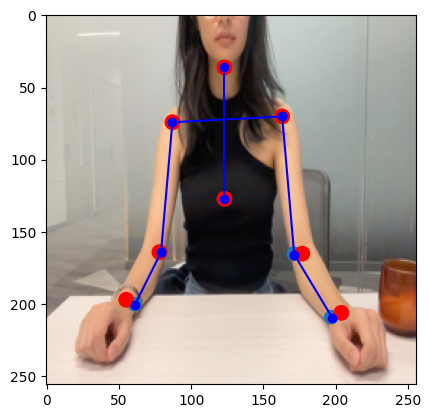

In [384]:
fig, ax = plt.subplots(1)
ax.set_aspect("equal")

image2 = np.squeeze(image, 0)
image2 = np.transpose(image2, (1, 2, 0))
ax.imshow(np.uint8(image2))
opt_locs = get_optimal_locations(pose_ret)

for loc in opt_locs:
    print(loc)
    ax.add_patch(Circle((int(loc[0]), int(loc[1]))))

r_se_x = [pose_ret[10], opt_locs[1][0]]
r_se_y = [pose_ret[11], opt_locs[1][1]]

l_se_x = [pose_ret[12], opt_locs[0][0]]
l_se_y = [pose_ret[13], opt_locs[0][1]]

r_ew_x = [opt_locs[1][0], opt_locs[3][0]]
r_ew_y = [opt_locs[1][1], opt_locs[3][1]]

l_ew_x = [opt_locs[0][0], opt_locs[2][0]]
l_ew_y = [opt_locs[0][1], opt_locs[2][1]]

plt.plot(r_se_x, r_se_y, 'bo', linestyle="-")
plt.plot(l_se_x, l_se_y, 'bo', linestyle="-")
plt.plot(r_ew_x, r_ew_y, 'bo', linestyle="-")
plt.plot(l_ew_x, l_ew_y, 'bo', linestyle="-")
plt.plot([pose_ret[10], pose_ret[12]], [pose_ret[11], pose_ret[13]], 'bo', linestyle="-")
plt.plot([pose_ret[0], pose_ret[2]], [pose_ret[1], pose_ret[3]], 'bo', linestyle="-")